# First Block

In [2]:
pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/5b/2b/d36d57c66ff031f93b4fa432e86802f84991477e522adcdffd314454326b/torch-2.7.1-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 33.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 31.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Uninstalling sympy-1.11.1:
      Successfully uninstalled sympy-1.11.1
Note: you may need to restart the kernel to use updated packages.


In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [62]:


def compute_bandpowers(signal, fs=256):
    freqs, psd = welch(signal, fs, nperseg=128)
    bandpowers = {
        'delta': np.mean(psd[(freqs >= 0.5) & (freqs < 4)]),
        'theta': np.mean(psd[(freqs >= 4) & (freqs < 8)]),
        'alpha': np.mean(psd[(freqs >= 8) & (freqs < 13)]),
        'beta':  np.mean(psd[(freqs >= 13) & (freqs < 30)]),
        'gamma': np.mean(psd[(freqs >= 30) & (freqs <= 100)])
    }
    return np.array(list(bandpowers.values()), dtype=np.float32)


def simulate_eeg(batch_size=32, seq_len=256, channels=8, num_classes=4):
    fs = 256
    t = np.linspace(0, 1, seq_len)
    X = np.zeros((batch_size, seq_len, channels))
    y = np.random.randint(0, num_classes, batch_size)
    band_features = np.zeros((batch_size, channels, 5))

    for i in range(batch_size):
        label = y[i]
        for ch in range(channels):
            signal = 10 * np.sin(2 * np.pi * 10 * t)
            if label == 0:
                signal += 5 * np.sin(2 * np.pi * 15 * t)
            elif label == 1:
                signal += 5 * np.sin(2 * np.pi * 6 * t)
            elif label == 2:
                signal += 5 * np.sin(2 * np.pi * 40 * t)
            else:
                signal += 5 * np.random.randn(seq_len)
            signal += np.random.randn(seq_len)

            X[i, :, ch] = signal
            band_features[i, ch] = compute_bandpowers(signal, fs)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    band_tensor = torch.tensor(band_features, dtype=torch.float32)  # shape: (B, C, 5)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, band_tensor, y_tensor


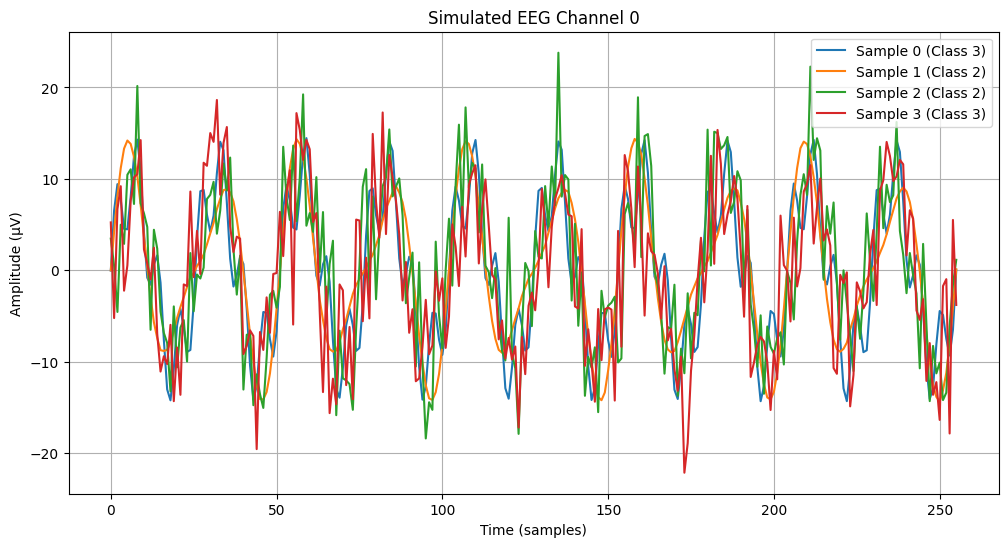

In [5]:
X, y = simulate_eeg(batch_size=4)[0], simulate_eeg(batch_size=4)[2]
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(X[i, :, 0].numpy(), label=f"Sample {i} (Class {y[i].item()})")
plt.title("Simulated EEG Channel 0")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)
plt.show()

# Second Block

In [63]:
def normalize_eeg(X):
  mean = X.mean(dim=1, keepdim=True)
  std = X.std(dim=1, keepdim=True)
  return (X - mean) / (std + 1e-6)

In [64]:
import torch.nn as nn

class EEGCompressorTransformer(nn.Module):
    def __init__(self, input_dim=8, bandpower_dim=5, embed_dim=32, num_heads=4, compressed_len=32):
        super().__init__()
        self.input_embed = nn.Linear(input_dim * (1 + bandpower_dim), embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 256, embed_dim))

        self.attn_layer = SaveAttnLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)

        self.pool = nn.AdaptiveAvgPool1d(compressed_len)
        self.output_dim = embed_dim * compressed_len


    def forward(self, x, band_feats):
      # x: (B, T, C), band_feats: (B, C, 5)
      B, T, C = x.shape

      # Expand band_feats across time dimension
      band_feats = band_feats.unsqueeze(1).repeat(1, T, 1, 1)  # (B, T, C, 5)

      # Bring input x to shape (B, T, C, 1) and concat
      x = x.unsqueeze(-1)  # (B, T, C, 1)
      x = torch.cat([x, band_feats], dim=-1)  # (B, T, C, 6)

      # Merge channel and feature dims: (B, T, C * 6)
      x = x.view(B, T, C * 6)

      x = self.input_embed(x) + self.pos_embed[:, :T, :]
      x = self.attn_layer(x)
      x = x.permute(0, 2, 1)
      x = self.pool(x).flatten(1)
      return x

# to save attention weights i am rewriting class
class SaveAttnLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_map = None

    def forward(self, src, src_mask=None, is_causal=False, src_key_padding_mask=None):

        src2, attn_weights = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            average_attn_weights=False,
            is_causal=is_causal
        )
        self.attn_map = attn_weights.detach()  # (batch, heads, tgt_len, src_len)

        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [65]:
compressor = EEGCompressorTransformer()
classifier = EEGClassifier(compressor.output_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compressor.to(device)
classifier.to(device)
X, band_feats, y = simulate_eeg()
X = normalize_eeg(X)
features = compressor(X.to(device), band_feats.to(device))

In [66]:
class EEGClassifier(nn.Module):
  def __init__(self, input_dim, num_classes=4):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(128, num_classes)
    )

  def forward(self, x):
    return self.net(x)


# Block 3

In [68]:
import torch.nn.functional as F
compressor = EEGCompressorTransformer()
classifier = EEGClassifier(compressor.output_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compressor.to(device)
classifier.to(device)

optimizer = torch.optim.Adam(
    list(compressor.parameters()) + list(classifier.parameters()), lr=1e-3)

EPOCHS=10
BATCH_SIZE=64

for epoch in range(EPOCHS):
  X, y = simulate_eeg(batch_size=BATCH_SIZE)
  X = normalize_eeg(X).to(device)
  y = y.to(device)

  X=  X #shape should be (batch, time, channels)

  #forwarding
  features = compressor(X)
  logits = classifier(features)
  loss = F.cross_entropy(logits, y)

  #backproping
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  acc = (logits.argmax(1) == y).float().mean()

  print(f"Epoch {epoch+1:02d}: Loss = {loss.item():.4f}, Accuracy = {acc.item()*100:.2f}%, Compression Ratio = {256 / 32:.1f}×")

ValueError: too many values to unpack (expected 2)

# Adding Test Set to Model

In [69]:
X_test, y_test = simulate_eeg(batch_size=256)
X_test = normalize_eeg(X_test).to(device)
y_test = y_test.to(device)

for epoch in range(EPOCHS):
  X_train, y_train  = simulate_eeg(batch_size=BATCH_SIZE)
  X_train = normalize_eeg(X_train).to(device)
  y_train = y_train.to(device)

  features = compressor(X_train)
  logits = classifier(features)
  loss = F.cross_entropy(logits, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  acc = (logits.argmax(1) == y_train).float().mean()

  #testing
  with torch.no_grad():
    test_features = compressor(X_test)
    test_logits = classifier(test_features)
    test_acc = (test_logits.argmax(1) == y_test).float().mean()

    print(f"Epoch {epoch+1:02d}: "
      f"Train Loss = {loss.item():.4f}, "
      f"Train Acc = {acc.item()*100:.2f}%, "
      f"Test Acc = {test_acc.item()*100:.2f}%")



ValueError: too many values to unpack (expected 2)

# Visuals

In [70]:


def plot_attention(model, input_signal, band_feats, head=0):
    model.eval()
    with torch.no_grad():
        _ = model(input_signal, band_feats)

    attn = model.attn_layer.attn_map  # (batch, heads, tgt_len, src_len)
    if attn is None:
        raise ValueError("No attention map recorded. Make sure a forward pass has occurred.")

    attn_map = attn[0, head].cpu().squeeze()  # (tgt_len, src_len)

    plt.figure(figsize=(6, 5))
    plt.imshow(attn_map, cmap='viridis', aspect='auto')
    plt.title(f"Attention Map (Head {head})")
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.colorbar()
    plt.tight_layout()
    plt.show()



In [14]:
compressor = EEGCompressorTransformer().to(device)
x_sample, _ = simulate_eeg(batch_size=1)
x_sample = normalize_eeg(x_sample).to(device)
_ = compressor(x_sample)
plot_attention(compressor, x_sample)

ValueError: too many values to unpack (expected 2)

In [15]:
EPOCHS = 50
BATCH_SIZE = 128

# Fixed test set
X_test, y_test = simulate_eeg(batch_size=256)
X_test = normalize_eeg(X_test).to(device)
y_test = y_test.to(device)

for epoch in range(1, EPOCHS + 1):
    X_train, y_train = simulate_eeg(batch_size=BATCH_SIZE)
    X_train = normalize_eeg(X_train).to(device)
    y_train = y_train.to(device)

    compressor.train()
    classifier.train()

    features = compressor(X_train)
    logits = classifier(features)
    loss = F.cross_entropy(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate
    compressor.eval()
    classifier.eval()
    with torch.no_grad():
        test_features = compressor(X_test)
        test_logits = classifier(test_features)
        test_acc = (test_logits.argmax(1) == y_test).float().mean()

    train_acc = (logits.argmax(1) == y_train).float().mean()

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {loss.item():.4f} | "
          f"Train Acc: {train_acc.item()*100:.2f}% | "
          f"Test Acc: {test_acc.item()*100:.2f}%")

    # Save and visualize attention every 10 epochs
    if epoch % 10 == 0:
        x_sample, _ = simulate_eeg(batch_size=1)
        x_sample = normalize_eeg(x_sample).to(device)
        _ = compressor(x_sample)
        plot_attention(compressor, x_sample)


ValueError: too many values to unpack (expected 2)

# Training and Plotting Attention Maps with Updated Transformer Model now containing richer time x frequency x spatial context

- Model now gets 48-dimensional feature vectors per timestep
- Attention can now learn across physiologically meaninful features

Epoch 01 | Train Loss: 1.3816 | Train Acc: 25.00% | Test Acc: 56.25%
Epoch 02 | Train Loss: 1.2992 | Train Acc: 39.06% | Test Acc: 27.73%
Epoch 03 | Train Loss: 1.3420 | Train Acc: 21.88% | Test Acc: 48.83%
Epoch 04 | Train Loss: 1.1604 | Train Acc: 48.44% | Test Acc: 41.02%
Epoch 05 | Train Loss: 1.2247 | Train Acc: 42.19% | Test Acc: 51.95%
Epoch 06 | Train Loss: 1.0853 | Train Acc: 48.44% | Test Acc: 52.73%
Epoch 07 | Train Loss: 0.9625 | Train Acc: 53.12% | Test Acc: 72.27%
Epoch 08 | Train Loss: 0.9353 | Train Acc: 60.94% | Test Acc: 57.81%
Epoch 09 | Train Loss: 0.8788 | Train Acc: 53.12% | Test Acc: 56.25%
Epoch 10 | Train Loss: 0.7625 | Train Acc: 62.50% | Test Acc: 76.56%


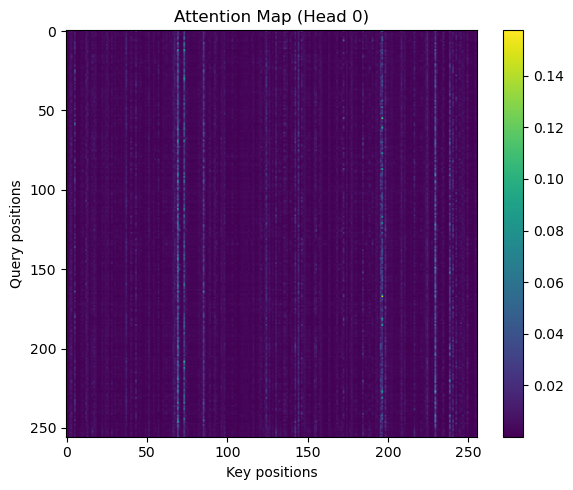

Epoch 11 | Train Loss: 0.7812 | Train Acc: 59.38% | Test Acc: 83.98%
Epoch 12 | Train Loss: 0.8286 | Train Acc: 71.88% | Test Acc: 79.69%
Epoch 13 | Train Loss: 0.7565 | Train Acc: 68.75% | Test Acc: 79.69%
Epoch 14 | Train Loss: 0.7594 | Train Acc: 59.38% | Test Acc: 79.69%
Epoch 15 | Train Loss: 0.5979 | Train Acc: 73.44% | Test Acc: 79.69%
Epoch 16 | Train Loss: 0.6090 | Train Acc: 71.88% | Test Acc: 86.33%
Epoch 17 | Train Loss: 0.6051 | Train Acc: 76.56% | Test Acc: 94.53%
Epoch 18 | Train Loss: 0.5144 | Train Acc: 90.62% | Test Acc: 82.03%
Epoch 19 | Train Loss: 0.5101 | Train Acc: 73.44% | Test Acc: 81.25%
Epoch 20 | Train Loss: 0.3997 | Train Acc: 84.38% | Test Acc: 83.59%


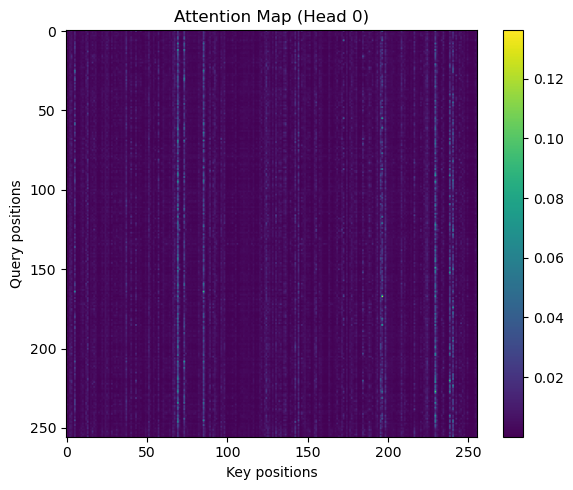

Epoch 21 | Train Loss: 0.2683 | Train Acc: 89.06% | Test Acc: 83.59%
Epoch 22 | Train Loss: 0.3862 | Train Acc: 73.44% | Test Acc: 90.62%
Epoch 23 | Train Loss: 0.3408 | Train Acc: 84.38% | Test Acc: 97.27%
Epoch 24 | Train Loss: 0.3554 | Train Acc: 87.50% | Test Acc: 87.50%
Epoch 25 | Train Loss: 0.3343 | Train Acc: 82.81% | Test Acc: 97.27%
Epoch 26 | Train Loss: 0.2804 | Train Acc: 93.75% | Test Acc: 72.27%
Epoch 27 | Train Loss: 0.2773 | Train Acc: 82.81% | Test Acc: 72.27%
Epoch 28 | Train Loss: 0.2811 | Train Acc: 78.12% | Test Acc: 98.83%
Epoch 29 | Train Loss: 0.2087 | Train Acc: 89.06% | Test Acc: 87.89%
Epoch 30 | Train Loss: 0.1934 | Train Acc: 92.19% | Test Acc: 83.98%


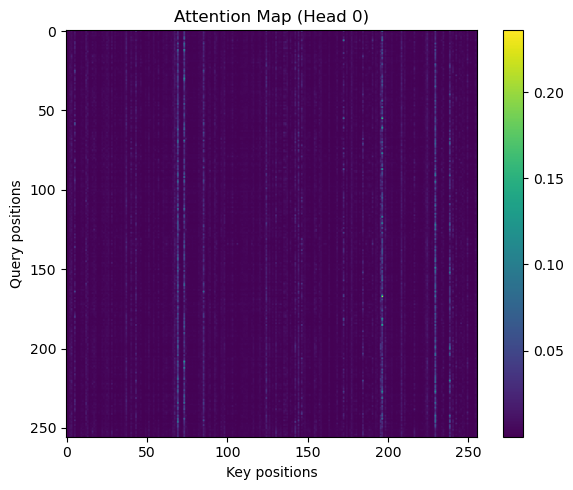

Epoch 31 | Train Loss: 0.2455 | Train Acc: 84.38% | Test Acc: 90.62%
Epoch 32 | Train Loss: 0.1850 | Train Acc: 95.31% | Test Acc: 96.48%
Epoch 33 | Train Loss: 0.2115 | Train Acc: 93.75% | Test Acc: 99.61%
Epoch 34 | Train Loss: 0.2002 | Train Acc: 90.62% | Test Acc: 96.88%
Epoch 35 | Train Loss: 0.1894 | Train Acc: 95.31% | Test Acc: 98.83%
Epoch 36 | Train Loss: 0.1658 | Train Acc: 96.88% | Test Acc: 99.61%
Epoch 37 | Train Loss: 0.1131 | Train Acc: 98.44% | Test Acc: 98.44%
Epoch 38 | Train Loss: 0.1563 | Train Acc: 95.31% | Test Acc: 98.83%
Epoch 39 | Train Loss: 0.1128 | Train Acc: 98.44% | Test Acc: 100.00%
Epoch 40 | Train Loss: 0.0996 | Train Acc: 98.44% | Test Acc: 100.00%


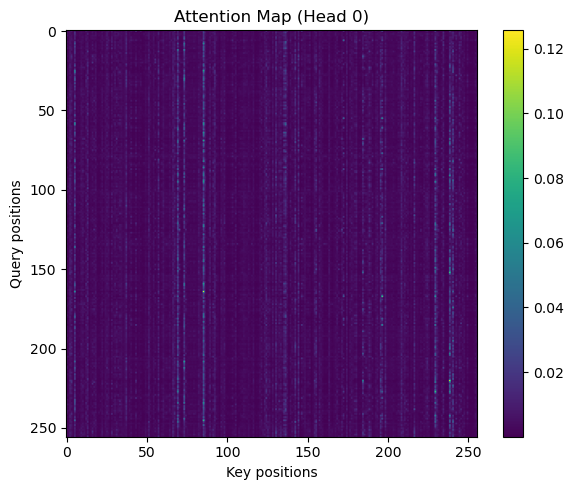

Epoch 41 | Train Loss: 0.1150 | Train Acc: 100.00% | Test Acc: 99.61%
Epoch 42 | Train Loss: 0.0799 | Train Acc: 98.44% | Test Acc: 99.61%
Epoch 43 | Train Loss: 0.0384 | Train Acc: 100.00% | Test Acc: 99.61%
Epoch 44 | Train Loss: 0.0410 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 45 | Train Loss: 0.0723 | Train Acc: 96.88% | Test Acc: 100.00%
Epoch 46 | Train Loss: 0.0582 | Train Acc: 98.44% | Test Acc: 100.00%
Epoch 47 | Train Loss: 0.0241 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 48 | Train Loss: 0.0156 | Train Acc: 100.00% | Test Acc: 99.61%
Epoch 49 | Train Loss: 0.0457 | Train Acc: 98.44% | Test Acc: 100.00%
Epoch 50 | Train Loss: 0.0141 | Train Acc: 100.00% | Test Acc: 100.00%


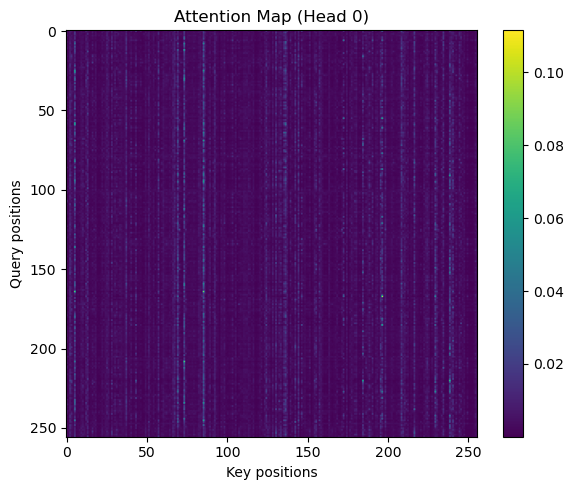

Epoch 51 | Train Loss: 0.0236 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 52 | Train Loss: 0.0101 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 53 | Train Loss: 0.0127 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 54 | Train Loss: 0.0112 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 55 | Train Loss: 0.0033 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 56 | Train Loss: 0.0062 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 57 | Train Loss: 0.0022 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 58 | Train Loss: 0.0189 | Train Acc: 98.44% | Test Acc: 100.00%
Epoch 59 | Train Loss: 0.0028 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 60 | Train Loss: 0.0055 | Train Acc: 100.00% | Test Acc: 100.00%


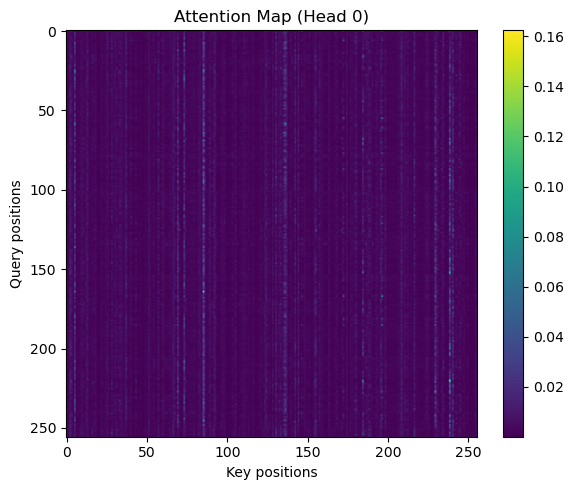

In [71]:
import torch.nn.functional as F
EPOCHS = 60
BATCH_SIZE = 64
optimizer = torch.optim.Adam(
    list(compressor.parameters()) + list(classifier.parameters()), lr=1e-3)

X_test, band_feats_test, y_test = simulate_eeg(batch_size=256)
X_test = normalize_eeg(X_test).to(device)
band_feats_test = band_feats_test.to(device)
y_test = y_test.to(device)

train_acc_log = []
test_acc_log = []

for epoch in range(1, EPOCHS+1):
  X_train, band_feats_train, y_train = simulate_eeg(batch_size=BATCH_SIZE)
  X_train = normalize_eeg(X_train).to(device)
  band_feats_train = band_feats_train.to(device)
  y_train = y_train.to(device)

  compressor.train()
  classifier.train()

  features = compressor(X_train, band_feats_train)
  logits = classifier(features)
  loss = F.cross_entropy(logits, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  compressor.eval()
  classifier.eval()
  with torch.no_grad():
    test_features = compressor(X_test, band_feats_test)
    test_logits = classifier(test_features)
    test_acc = (test_logits.argmax(1) == y_test).float().mean()
  train_acc = (logits.argmax(1) == y_train).float().mean()

  train_acc_log.append(train_acc.item())
  test_acc_log.append(test_acc.item())

  print(f"Epoch {epoch:02d} | "
          f"Train Loss: {loss.item():.4f} | "
          f"Train Acc: {train_acc.item()*100:.2f}% | "
          f"Test Acc: {test_acc.item()*100:.2f}%")

  if epoch % 10 == 0:
    x_sample, band_sample, _ = simulate_eeg(batch_size=1)
    x_sample = normalize_eeg(x_sample).to(device)
    band_sample = band_sample.to(device)

    _ = compressor (x_sample, band_sample)
    plot_attention(compressor, x_sample, band_sample)


<Figure size 800x500 with 0 Axes>

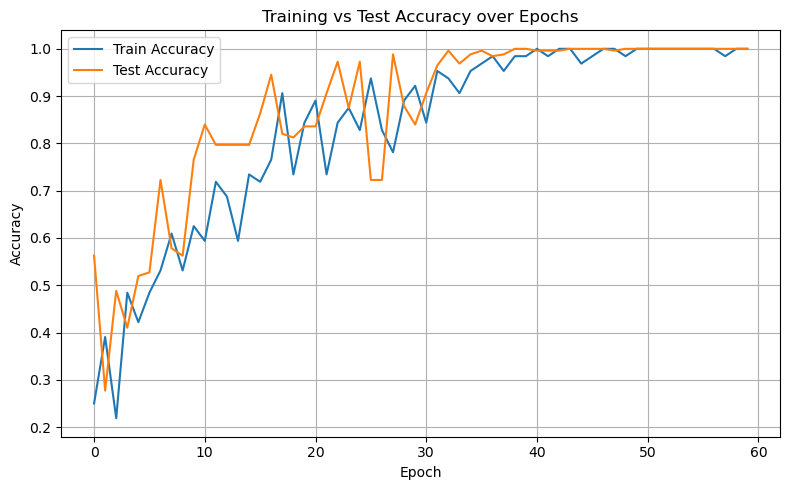

In [72]:
plt.figure(figsize=(8,5))

plt.figure(figsize=(8, 5))
plt.plot(train_acc_log, label="Train Accuracy")
plt.plot(test_acc_log, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
final_accuracy = test_acc_log[-1]
print(f"Final Accuracy: {final_accuracy * 100:.2f}%")
max_accuracy = max(test_acc_log)
print(f"Maximum Accuracy: {max_accuracy * 100:.2f}%")

Final Accuracy: 100.00%
Maximum Accuracy: 100.00%


# Phase 2 - Spatial Graph Modelling

In [ ]:
EEG [B, T, C] ──▶ GCN (per-timestep channel graph)
                    ↓
       [B, T, C'] (spatially-mixed features)
                    ↓
        Transformer Encoder (temporal attention)
                    ↓
       Classifier (compressed output → class)


In [20]:
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html



In [21]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch

# Creating Spatial Graph Layer (GCN)
Each time slice gets processed by a GCN layer across the 8 channels

In [22]:
class EEGSpatialGraph(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):
        super().__init__()
        self.gcn = GCNConv(in_channels, out_channels)
        self.out_channels = out_channels
        # Predefine undirected 8-channel graph
        edge_index = torch.combinations(torch.arange(8), r=2).t()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # make bidirectional
        self.register_buffer("edge_index", edge_index)  # properly moves with model

    def forward(self, x):
        # x: (B, T, C)
        B, T, C = x.shape
        outputs = []

        for b in range(B):
            batch_out = []
            for t in range(T):
                signal = x[b, t].view(-1, 1)  # (C, 1)
                data = Data(x=signal, edge_index=self.edge_index)
                data = data.to(signal.device)  # move edge_index to same device
                out = self.gcn(data.x, data.edge_index)
                batch_out.append(out.T)  # (out_channels, C)
            batch_out = torch.stack(batch_out, dim=1)  # (out_channels, T, C)
            outputs.append(batch_out)

        output = torch.stack(outputs)  # (B, out_channels, T, C)
        output = output.permute(0, 2, 3, 1)  # (B, T, C, out_channels)
        return output.reshape(B, T, C * self.out_channels)



In [23]:
# new EEGGraphTransformerClass (for easy debugging)

class EEGGraphTransformerNew(nn.Module):
    def __init__(self, input_dim=8, bandpower_dim=5, embed_dim=32, num_heads=4, compressed_len=32):
        super().__init__()
        self.graph_block = EEGSpatialGraph(in_channels=1, out_channels=4)
        self.input_embed = nn.Linear(input_dim * self.graph_block.out_channels + bandpower_dim * input_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 256, embed_dim))
        self.attn_layer = SaveAttnLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.pool = nn.AdaptiveAvgPool1d(compressed_len)
        self.output_dim = embed_dim * compressed_len

    def forward(self, x, band_feats):
      B, T, C = x.shape
      gcn_out = self.graph_block(x) # (B, T, C, * 4)

      band_feats = band_feats.unsqueeze(1).repeat(1, T, 1, 1)
      band_feats = band_feats.permute(0, 2, 1, 3).reshape(B, T, C * 5)
      x = torch.cat([gcn_out, band_feats], dim=-1)
      x = self.input_embed(x) + self.pos_embed[:, :T, :]
      x = self.attn_layer(x)
      x = x.permute(0, 2, 1)
      x = self.pool(x).flatten(1)
      return x

# Training

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compressor_new = EEGGraphTransformerNew().to(device)

Epoch 01 | Train Loss: 3.4516 | Train Acc: 18.75% | Test Acc: 25.78%
Epoch 02 | Train Loss: 7.0935 | Train Acc: 18.75% | Test Acc: 28.52%
Epoch 03 | Train Loss: 8.7351 | Train Acc: 31.25% | Test Acc: 54.30%
Epoch 04 | Train Loss: 7.4014 | Train Acc: 25.00% | Test Acc: 25.78%
Epoch 05 | Train Loss: 5.5205 | Train Acc: 21.88% | Test Acc: 25.78%
Epoch 06 | Train Loss: 3.2158 | Train Acc: 37.50% | Test Acc: 25.78%
Epoch 07 | Train Loss: 2.2801 | Train Acc: 37.50% | Test Acc: 25.78%
Epoch 08 | Train Loss: 3.0853 | Train Acc: 31.25% | Test Acc: 19.92%
Epoch 09 | Train Loss: 2.2966 | Train Acc: 34.38% | Test Acc: 19.92%
Epoch 10 | Train Loss: 1.5138 | Train Acc: 28.12% | Test Acc: 48.44%


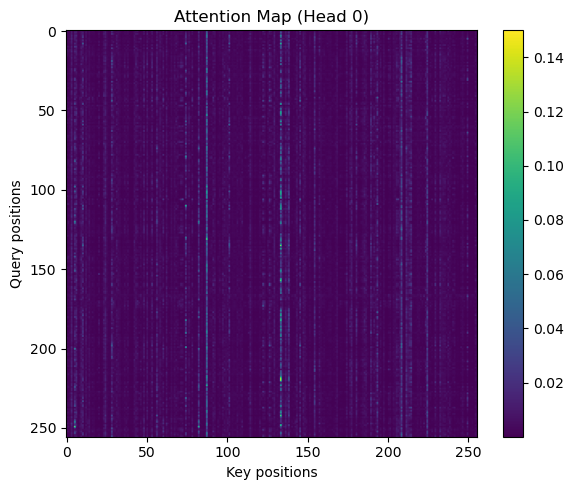

Epoch 11 | Train Loss: 1.6549 | Train Acc: 31.25% | Test Acc: 28.52%
Epoch 12 | Train Loss: 1.4705 | Train Acc: 37.50% | Test Acc: 28.52%
Epoch 13 | Train Loss: 1.6156 | Train Acc: 31.25% | Test Acc: 28.52%
Epoch 14 | Train Loss: 1.6497 | Train Acc: 21.88% | Test Acc: 28.52%
Epoch 15 | Train Loss: 1.5205 | Train Acc: 28.12% | Test Acc: 28.52%
Epoch 16 | Train Loss: 1.1189 | Train Acc: 46.88% | Test Acc: 28.52%
Epoch 17 | Train Loss: 1.3189 | Train Acc: 28.12% | Test Acc: 28.52%
Epoch 18 | Train Loss: 1.3131 | Train Acc: 28.12% | Test Acc: 54.30%
Epoch 19 | Train Loss: 1.3524 | Train Acc: 21.88% | Test Acc: 54.30%
Epoch 20 | Train Loss: 1.2976 | Train Acc: 37.50% | Test Acc: 54.30%


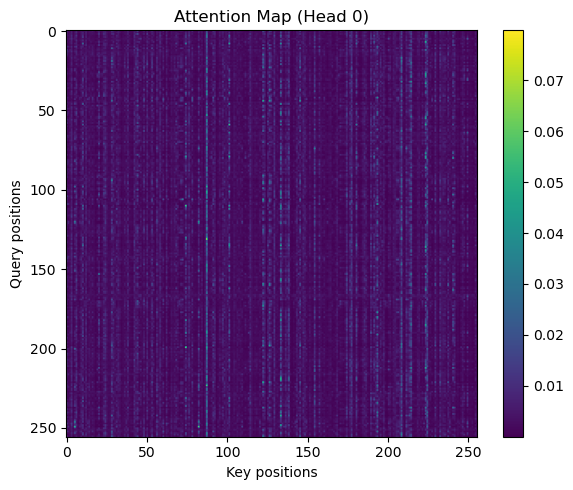

Epoch 21 | Train Loss: 1.3241 | Train Acc: 34.38% | Test Acc: 32.42%
Epoch 22 | Train Loss: 1.2904 | Train Acc: 43.75% | Test Acc: 19.92%
Epoch 23 | Train Loss: 1.3077 | Train Acc: 31.25% | Test Acc: 19.92%
Epoch 24 | Train Loss: 1.2984 | Train Acc: 43.75% | Test Acc: 45.70%
Epoch 25 | Train Loss: 1.3331 | Train Acc: 34.38% | Test Acc: 48.44%
Epoch 26 | Train Loss: 1.3153 | Train Acc: 43.75% | Test Acc: 48.44%
Epoch 27 | Train Loss: 1.3025 | Train Acc: 25.00% | Test Acc: 48.44%
Epoch 28 | Train Loss: 1.3042 | Train Acc: 34.38% | Test Acc: 48.44%
Epoch 29 | Train Loss: 1.3206 | Train Acc: 37.50% | Test Acc: 48.44%
Epoch 30 | Train Loss: 1.2993 | Train Acc: 34.38% | Test Acc: 48.44%


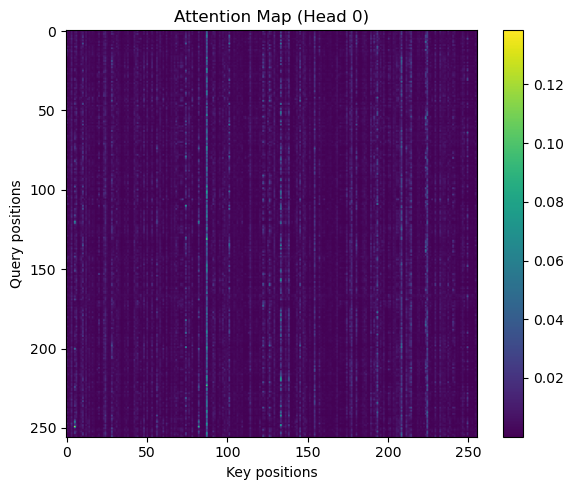

Epoch 31 | Train Loss: 1.2138 | Train Acc: 46.88% | Test Acc: 48.44%
Epoch 32 | Train Loss: 1.3009 | Train Acc: 31.25% | Test Acc: 48.44%
Epoch 33 | Train Loss: 1.2757 | Train Acc: 25.00% | Test Acc: 48.44%
Epoch 34 | Train Loss: 1.1950 | Train Acc: 53.12% | Test Acc: 48.44%
Epoch 35 | Train Loss: 1.1935 | Train Acc: 46.88% | Test Acc: 48.44%
Epoch 36 | Train Loss: 1.1868 | Train Acc: 56.25% | Test Acc: 48.44%
Epoch 37 | Train Loss: 1.1370 | Train Acc: 53.12% | Test Acc: 48.44%
Epoch 38 | Train Loss: 1.1082 | Train Acc: 43.75% | Test Acc: 48.44%
Epoch 39 | Train Loss: 1.1789 | Train Acc: 40.62% | Test Acc: 48.44%
Epoch 40 | Train Loss: 1.0819 | Train Acc: 53.12% | Test Acc: 48.44%


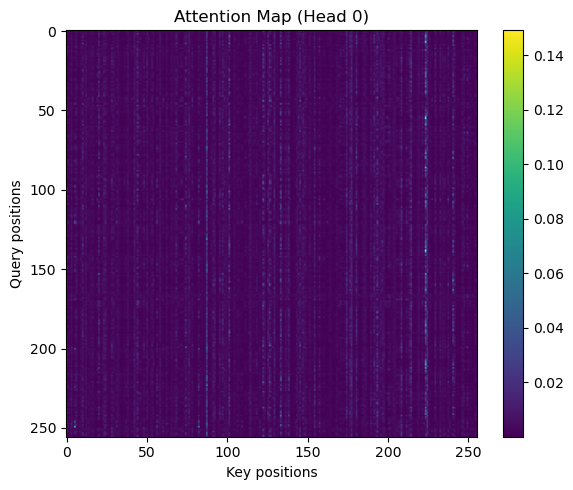

Epoch 41 | Train Loss: 1.0610 | Train Acc: 46.88% | Test Acc: 48.44%
Epoch 42 | Train Loss: 0.9643 | Train Acc: 53.12% | Test Acc: 48.44%
Epoch 43 | Train Loss: 0.9442 | Train Acc: 56.25% | Test Acc: 48.44%
Epoch 44 | Train Loss: 1.1191 | Train Acc: 40.62% | Test Acc: 48.44%
Epoch 45 | Train Loss: 1.0243 | Train Acc: 46.88% | Test Acc: 48.44%
Epoch 46 | Train Loss: 0.8843 | Train Acc: 59.38% | Test Acc: 54.30%
Epoch 47 | Train Loss: 1.0131 | Train Acc: 53.12% | Test Acc: 54.30%
Epoch 48 | Train Loss: 0.9482 | Train Acc: 50.00% | Test Acc: 54.30%
Epoch 49 | Train Loss: 1.0414 | Train Acc: 53.12% | Test Acc: 54.30%
Epoch 50 | Train Loss: 0.9733 | Train Acc: 50.00% | Test Acc: 54.30%


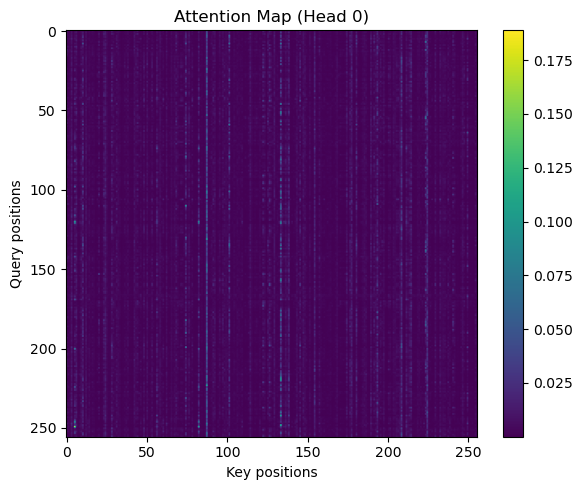

Epoch 51 | Train Loss: 1.1736 | Train Acc: 40.62% | Test Acc: 54.30%
Epoch 52 | Train Loss: 0.8425 | Train Acc: 53.12% | Test Acc: 54.30%
Epoch 53 | Train Loss: 0.9398 | Train Acc: 59.38% | Test Acc: 54.30%
Epoch 54 | Train Loss: 0.9649 | Train Acc: 40.62% | Test Acc: 70.70%
Epoch 55 | Train Loss: 0.9601 | Train Acc: 56.25% | Test Acc: 48.83%
Epoch 56 | Train Loss: 0.8565 | Train Acc: 53.12% | Test Acc: 48.83%
Epoch 57 | Train Loss: 0.9050 | Train Acc: 40.62% | Test Acc: 48.83%
Epoch 58 | Train Loss: 0.8484 | Train Acc: 53.12% | Test Acc: 48.83%
Epoch 59 | Train Loss: 0.9082 | Train Acc: 43.75% | Test Acc: 72.66%
Epoch 60 | Train Loss: 0.7947 | Train Acc: 62.50% | Test Acc: 54.30%


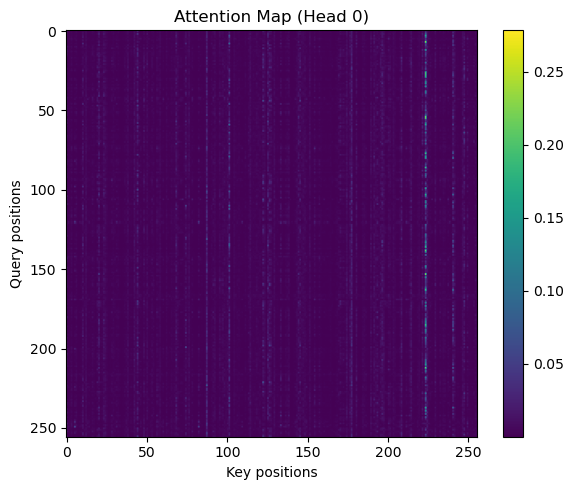

Epoch 61 | Train Loss: 0.7926 | Train Acc: 53.12% | Test Acc: 80.08%
Epoch 62 | Train Loss: 0.9970 | Train Acc: 56.25% | Test Acc: 80.08%
Epoch 63 | Train Loss: 0.9116 | Train Acc: 62.50% | Test Acc: 100.00%
Epoch 64 | Train Loss: 0.7953 | Train Acc: 75.00% | Test Acc: 49.22%
Epoch 65 | Train Loss: 0.9286 | Train Acc: 53.12% | Test Acc: 48.44%
Epoch 66 | Train Loss: 0.9306 | Train Acc: 40.62% | Test Acc: 48.44%
Epoch 67 | Train Loss: 0.7766 | Train Acc: 53.12% | Test Acc: 87.50%
Epoch 68 | Train Loss: 0.7790 | Train Acc: 68.75% | Test Acc: 100.00%
Epoch 69 | Train Loss: 0.6887 | Train Acc: 71.88% | Test Acc: 100.00%
Epoch 70 | Train Loss: 0.7691 | Train Acc: 75.00% | Test Acc: 88.28%


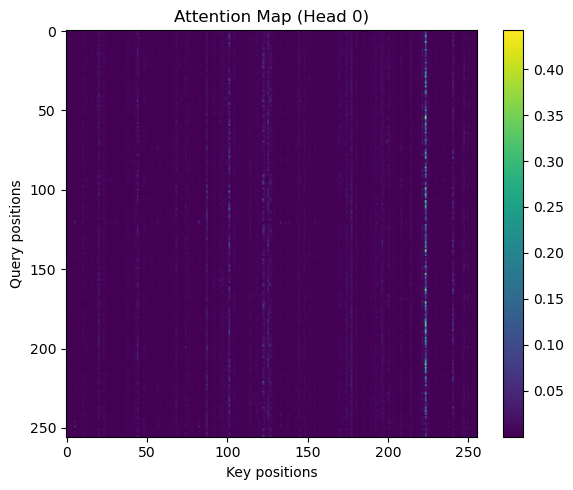

Epoch 71 | Train Loss: 0.6479 | Train Acc: 75.00% | Test Acc: 74.61%
Epoch 72 | Train Loss: 0.6112 | Train Acc: 81.25% | Test Acc: 74.22%
Epoch 73 | Train Loss: 0.5538 | Train Acc: 75.00% | Test Acc: 74.22%
Epoch 74 | Train Loss: 0.6353 | Train Acc: 68.75% | Test Acc: 75.78%
Epoch 75 | Train Loss: 0.4244 | Train Acc: 87.50% | Test Acc: 86.72%
Epoch 76 | Train Loss: 0.4915 | Train Acc: 75.00% | Test Acc: 94.53%
Epoch 77 | Train Loss: 0.6123 | Train Acc: 78.12% | Test Acc: 75.78%
Epoch 78 | Train Loss: 0.7406 | Train Acc: 56.25% | Test Acc: 94.14%
Epoch 79 | Train Loss: 0.4292 | Train Acc: 84.38% | Test Acc: 100.00%
Epoch 80 | Train Loss: 0.3616 | Train Acc: 87.50% | Test Acc: 100.00%


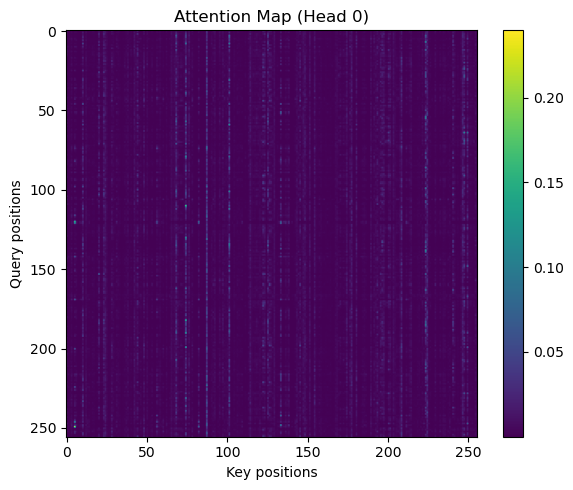

Epoch 81 | Train Loss: 0.3296 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 82 | Train Loss: 0.5295 | Train Acc: 78.12% | Test Acc: 98.44%
Epoch 83 | Train Loss: 0.5151 | Train Acc: 81.25% | Test Acc: 100.00%
Epoch 84 | Train Loss: 0.3613 | Train Acc: 87.50% | Test Acc: 100.00%
Epoch 85 | Train Loss: 0.5992 | Train Acc: 65.62% | Test Acc: 100.00%
Epoch 86 | Train Loss: 0.3463 | Train Acc: 87.50% | Test Acc: 100.00%
Epoch 87 | Train Loss: 0.3770 | Train Acc: 87.50% | Test Acc: 100.00%
Epoch 88 | Train Loss: 0.2563 | Train Acc: 90.62% | Test Acc: 100.00%
Epoch 89 | Train Loss: 0.2551 | Train Acc: 87.50% | Test Acc: 100.00%
Epoch 90 | Train Loss: 0.1154 | Train Acc: 100.00% | Test Acc: 99.61%


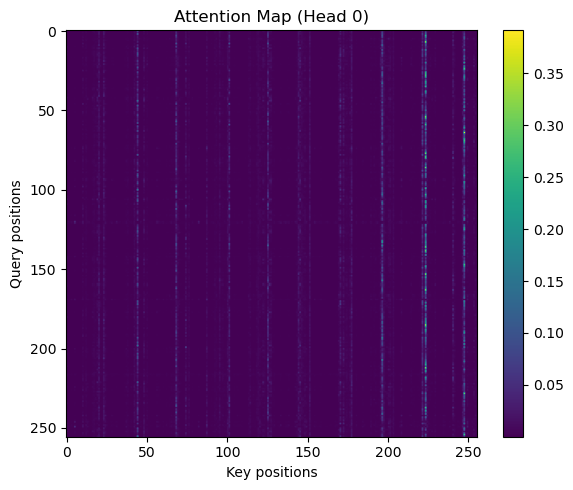

Epoch 91 | Train Loss: 0.4299 | Train Acc: 78.12% | Test Acc: 100.00%
Epoch 92 | Train Loss: 0.2480 | Train Acc: 84.38% | Test Acc: 100.00%
Epoch 93 | Train Loss: 0.3149 | Train Acc: 84.38% | Test Acc: 100.00%
Epoch 94 | Train Loss: 0.1738 | Train Acc: 93.75% | Test Acc: 99.61%
Epoch 95 | Train Loss: 0.1365 | Train Acc: 96.88% | Test Acc: 98.83%
Epoch 96 | Train Loss: 0.1670 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 97 | Train Loss: 0.3345 | Train Acc: 78.12% | Test Acc: 99.61%
Epoch 98 | Train Loss: 0.1221 | Train Acc: 96.88% | Test Acc: 99.61%
Epoch 99 | Train Loss: 0.2615 | Train Acc: 87.50% | Test Acc: 100.00%
Epoch 100 | Train Loss: 0.1354 | Train Acc: 96.88% | Test Acc: 100.00%


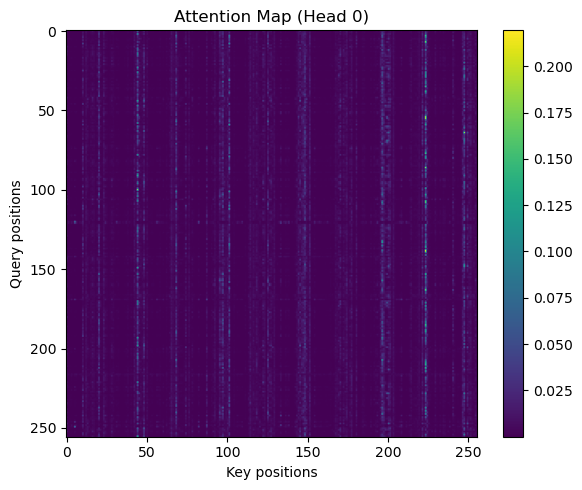

Epoch 101 | Train Loss: 0.2974 | Train Acc: 90.62% | Test Acc: 100.00%
Epoch 102 | Train Loss: 0.1698 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 103 | Train Loss: 0.1804 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 104 | Train Loss: 0.1948 | Train Acc: 90.62% | Test Acc: 100.00%
Epoch 105 | Train Loss: 0.1303 | Train Acc: 96.88% | Test Acc: 100.00%
Epoch 106 | Train Loss: 0.1234 | Train Acc: 96.88% | Test Acc: 100.00%
Epoch 107 | Train Loss: 0.1524 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 108 | Train Loss: 0.0591 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 109 | Train Loss: 0.1103 | Train Acc: 96.88% | Test Acc: 100.00%
Epoch 110 | Train Loss: 0.1034 | Train Acc: 96.88% | Test Acc: 100.00%


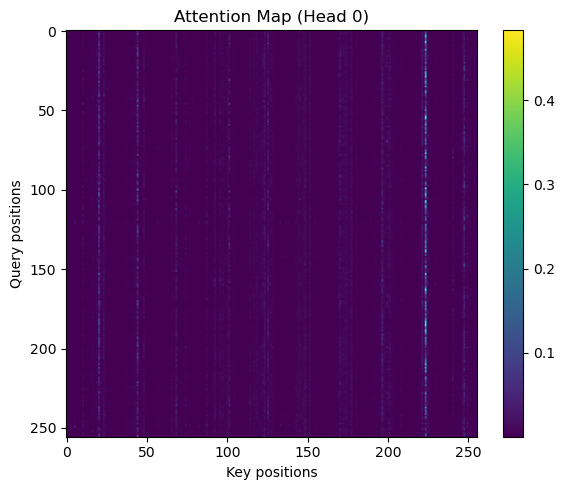

Epoch 111 | Train Loss: 0.2056 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 112 | Train Loss: 0.0721 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 113 | Train Loss: 0.0733 | Train Acc: 96.88% | Test Acc: 100.00%
Epoch 114 | Train Loss: 0.1001 | Train Acc: 96.88% | Test Acc: 99.61%
Epoch 115 | Train Loss: 0.0540 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 116 | Train Loss: 0.1289 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 117 | Train Loss: 0.1788 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 118 | Train Loss: 0.1709 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 119 | Train Loss: 0.1731 | Train Acc: 93.75% | Test Acc: 100.00%
Epoch 120 | Train Loss: 0.1218 | Train Acc: 96.88% | Test Acc: 100.00%


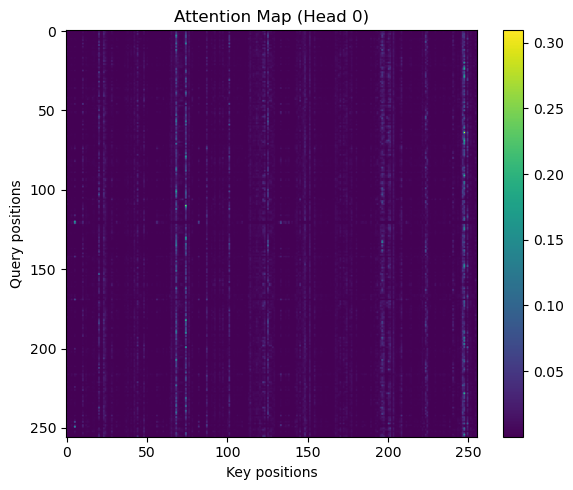

In [32]:
EPOCHS = 120
BATCH_SIZE = 32

train_acc_log = []
test_acc_log = []

X_test, band_feats_test, y_test = simulate_eeg(batch_size=256)
X_test = normalize_eeg(X_test).to(device)
band_feats_test = band_feats_test.to(device)
y_test = y_test.to(device)
optimizer = torch.optim.Adam(
    list(compressor_new.parameters()) + list(classifier.parameters()), lr=2e-3
)
for epoch in range(1, EPOCHS + 1):
    X_train, band_feats_train, y_train = simulate_eeg(batch_size=BATCH_SIZE)
    X_train = normalize_eeg(X_train).to(device)
    band_feats_train = band_feats_train.to(device)
    y_train = y_train.to(device)

    compressor_new.train()
    classifier.train()

    features = compressor_new(X_train, band_feats_train)  # ✅ fix name
    logits = classifier(features)
    loss = F.cross_entropy(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    compressor_new.eval()
    classifier.eval()
    with torch.no_grad():
        test_features = compressor_new(X_test, band_feats_test)
        test_logits = classifier(test_features)
        test_acc = (test_logits.argmax(1) == y_test).float().mean()

    train_acc = (logits.argmax(1) == y_train).float().mean()
    train_acc_log.append(train_acc.item())
    test_acc_log.append(test_acc.item())

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {loss.item():.4f} | "
          f"Train Acc: {train_acc.item()*100:.2f}% | "
          f"Test Acc: {test_acc.item()*100:.2f}%")

    if epoch % 10 == 0:
        x_sample, band_sample, _ = simulate_eeg(batch_size=1)
        x_sample = normalize_eeg(x_sample).to(device)
        band_sample = band_sample.to(device)
        with torch.no_grad():
            _ = compressor_new(x_sample, band_sample)
        plot_attention(compressor_new, x_sample, band_sample)


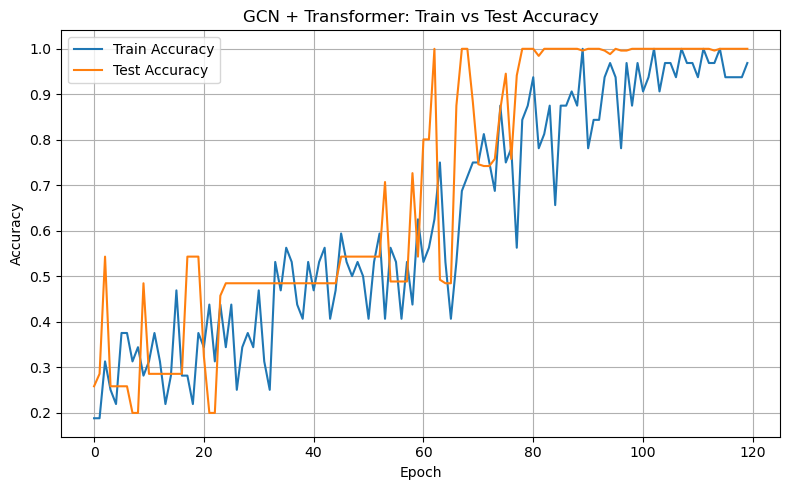

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc_log, label="Train Accuracy")
plt.plot(test_acc_log, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GCN + Transformer: Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
final_gcn_accuracy = test_acc_log[-1]
print(f"Final GCN Accuracy: {final_gcn_accuracy * 100:.2f}%")
max_gcn_accuracy = max(test_acc_log)
print(f"Maximum GCN Accuracy: {max_gcn_accuracy * 100:.2f}%")

Final GCN Accuracy: 100.00%
Maximum GCN Accuracy: 100.00%


# Testing on Real Dataset

In [36]:
import mne

In [50]:
raw = mne.io.read_raw_gdf('A01T.gdf', preload=True)
raw.filter(0.5, 40, fir_design='firwin')
raw.resample(256)

raw.pick_types(eeg=True)
events, event_id = mne.events_from_annotations(raw)
eeg_data = raw.get_data()

Extracting EDF parameters from /Users/jaivalpatel/Desktop/TransformerBCIEncoder/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/Users/jaivalpatel/anaconda3/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


In [53]:
print(event_id)
TRIAL_LEN = 768  # 3 seconds at 256 Hz
OFFSET = int(0.5 * 256)  # Start 0.5s after cue

MOTOR_IDS = [7, 8, 9, 10]  # event codes for motor classes
X = []
y = []

for onset, _, label in events:
    if label in MOTOR_IDS:
        start = onset + OFFSET
        end = start + TRIAL_LEN
        if end <= eeg_data.shape[1]:
            segment = eeg_data[:, start:end]
            X.append(segment)
            y.append(MOTOR_IDS.index(label))  # Map 7→0, 8→1, etc.

print(f"Extracted {len(X)} trials.")

X = np.stack(X)  # shape: (N, C, T)
y = np.array(y)
X_tensor = torch.tensor(X).float().permute(0, 2, 1) 
y_tensor = torch.tensor(y).long() 
print("X Shape: ", X_tensor.shape) 
print("Y Shape: ", torch.bincount(y_tensor))


{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Extracted 288 trials.
X Shape:  torch.Size([288, 768, 25])
Y Shape:  tensor([72, 72, 72, 72])


In [57]:
input_dim = 25
compressor_baseline = EEGCompressorTransformer(input_dim=input_dim).to(device)
compressor_gcn = EEGGraphTransformerNew(input_dim=input_dim).to(device)
classifier = EEGClassifier(input_dim=compressor_baseline.output_dim).to(device)

In [58]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training Loop on real dataset

In [60]:
# Baseline
import torch.nn.functional as F
optimizer = torch.optim.Adam(
    list(compressor_baseline.parameters()) + list(classifier.parameters()), lr=1e-3
)
B, T, C = X_batch.shape # not using Fourier yet 
dummy_band_feats = torch.zeros(B, C, 5).to(device)

features = compressor_baseline(X_batch, dummy_band_feats)

for epoch in range(20):
    compressor_baseline.train() 
    classifier.train()
    total_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
        
        features = compressor_baseline(X_batch) 
        logits = classifier(features)
        loss = F.cross_entropy(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        total_acc += (logits.argmax(1) == y_batch).sum().item() 
    
    acc = total_acc / len(X_tensor)
    print(f"[Baseline] Epoch {epoch+1}: Train Accuracy = {acc*100:.2f}%")
        

RuntimeError: The size of tensor a (768) must match the size of tensor b (256) at non-singleton dimension 1